In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [144]:
import allensdk_lims.internal.core.lims_utilities as lu
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.ephys.extract_cell_features import extract_cell_features

import os
from collections import defaultdict
import json
import pg8000

1. import json files so we can get cell level qc data
2. look at 2015 and then 2016 pass/fails and add annotations for move, new hires, personal changes, increased mice, pilots, project milestones
3. change histos to heatmaps
4. improve data vis
5. check slice on rig to last known time

In [142]:
def get_spec_name(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%ephys_features.json'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        print "Could not find json file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()
    
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],SplitLinux[5],''))


In [168]:
#load the JSON metadata csv as a df
df = pd.read_csv('JSON-metadata.csv')

#change the NaN to 0 in all time columns
df['Approach Time'].fillna(0)
df['End/Abort Time'].fillna(0)
df['Slice on Rig Time'].fillna(0)

cr = pd.read_csv('custom_report.csv')
new_columns = ['qc_state','seal','json_path','access_res','access_ratio','blowout']

for i in new_columns:
    df[i] = None
for i,time in enumerate(df['Approach Time']):
    if time != 0:
        df['Approach Time'][i] = datetime.strptime(time[:-3],"%H:%M")
    if df['End/Abort Time'][i] != '0':
        df['End/Abort Time'][i] = datetime.strptime(df['End/Abort Time'][i][:-3],"%H:%M")
    if df['Slice on Rig Time'][i] != '0':
        df['Slice on Rig Time'][i] = datetime.strptime(df['Slice on Rig Time'][i],"%H:%M")
    if df['Outcome'][i] == 'SUCCESS':
        df['json_path'][i] = get_spec_name(df['Specimen Name'][i])
        if df['json_path'][i] != None:
            with open(df['json_path'][i], 'r') as f:
                data = json.load(f)
            df['qc_state'][i] = cr.loc[cr['cell_specimen_name'] == df['Specimen Name'][i],'ephys_qc'].item()
            df['seal'][i] = data['seal_gohm']
            df['access_res'][i] = data['initial_access_resistance_mohm']
            df['access_ratio'][i] = data['input_access_resistance_ratio']
            df['blowout'][i] = data['blowout_mv']

ValueError: can only convert an array of size 1 to a Python scalar

In [178]:
#df['Specimen Name'][i]
print df['Specimen Name'][12]
cr[cr['cell_specimen_name'] == df['Specimen Name'][12]]

Ndnf-IRES2-dgCre;Ai14-290382.05.01.01


,project,cell_specimen_id,cell_specimen_name,patched_cell_container,ephys_roi_result_id,recording_date,tcp_sop,ephys_qc,dendrite_type,apical,image_series_20x_id,image_series_20x_qc,image_series_63x_id,image_series_63x_qc,has_morph_thumb,nwb_filename


In [177]:
df['Specimen Name'][12] == 'Ndnf-IRES2-dgCre;Ai14-290382.05.01.01'

True

In [114]:
# how do I add the qc state and then have a searchable method for failure reasons?
cr = pd.read_csv('custom_report.csv')
new_columns = ['qc_state','seal','json_path','access_res','access_ratio','blowout']
sorted(cr.columns)

['apical',
 'cell_specimen_id',
 'cell_specimen_name',
 'dendrite_type',
 'ephys_qc',
 'ephys_roi_result_id',
 'has_morph_thumb',
 'image_series_20x_id',
 'image_series_20x_qc',
 'image_series_63x_id',
 'image_series_63x_qc',
 'nwb_filename',
 'patched_cell_container',
 'project',
 'recording_date',
 'tcp_sop']

In [ ]:
def json_feature_parse(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    seal = data['seal_gohm']
    access_res = data['initial_access_resistance_mohm']
    access_ratio = data['input_access_resistance_ratio']
    blowout = data['blowout_mv']
    
    

In [154]:
file_name = get_spec_name('Sim1-Cre_KJ18;Ai14-281330.05.01.0')
print file_name

Could not find specimen result for Sim1-Cre_KJ18;Ai14-281330.05.01.0. Skipping...
None


In [151]:
sorted(data.keys())

[u'blowout_mv',
 u'created_at',
 u'electrode_0_pa',
 u'ephys_qc_criteria',
 u'ephys_qc_criteria_id',
 u'ephys_specimen_roi_plan_id',
 u'failed_bad_rs',
 u'failed_clogged_pipette',
 u'failed_electrode_0',
 u'failed_no_seal',
 u'failed_other',
 u'id',
 u'initial_access_resistance_mohm',
 u'input_access_resistance_ratio',
 u'input_resistance_mohm',
 u'notes',
 u'published_at',
 u'qc_notes',
 u'recording_date',
 u'rig_name',
 u'sampling_rate',
 u'seal_gohm',
 u'specimen',
 u'specimens',
 u'stage1_reviewer_id',
 u'stage2_reviewer_id',
 u'storage_directory',
 u'updated_at',
 u'well_known_files',
 u'workflow_state']

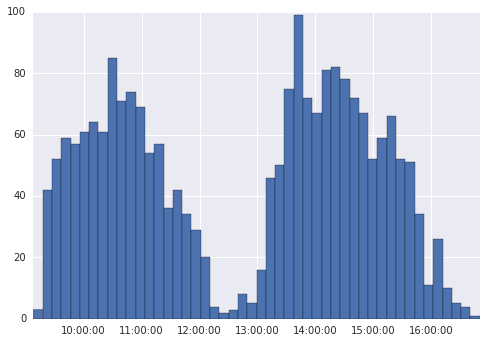

In [124]:
histo_df = df[df['Approach Time'] >=pd.Timestamp('1900-01-01 09:00:00')]
histo_df = histo_df[histo_df['Approach Time'] < pd.Timestamp('1900-01-01 17:00:00')]

ax = histo_df['Approach Time'].hist(bins = 48)
#ax.set_xticks(rotation = 'vertical')

# 1) Let's look at a heatmap of rig usage by operators

DiJon Hill 24.0
Lindsay Ng 22.0
Lisa Kim 37.0
Sam Josephsen 33.0


(array([ 693596.375     ,  693596.41666667,  693596.45833333,
         693596.5       ,  693596.54166667,  693596.58333333,
         693596.625     ,  693596.66666667,  693596.70833333]),
 <a list of 9 Text xticklabel objects>)

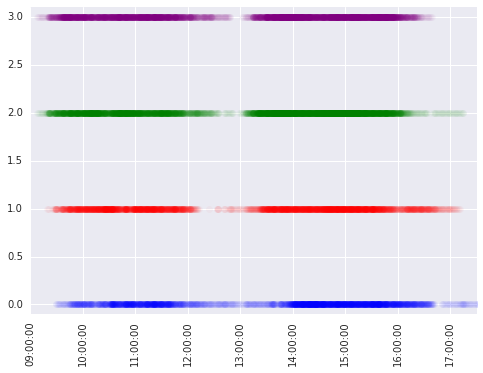

In [125]:
from collections import Counter

histo_df = df[df['Approach Time'] >=pd.Timestamp('1900-01-01 09:00:00')]
histo_df = histo_df[histo_df['Approach Time'] <=pd.Timestamp('1900-01-01 18:00:00')]
histo_df = histo_df[histo_df['End/Abort Time'] != '0']
#only worried about mouse IVSCC for this
histo_df = histo_df[histo_df['Cre Status'] != 'human']


rig_ops = ['DiJon Hill', 'Lindsay Ng',
       'Lisa Kim', 'Sam Josephsen']
colors = ['blue', 'red', 'green', 'purple']


for j, ops in enumerate(rig_ops):
    total_time = []
    temp_df = histo_df[histo_df['Rig Operator'] == ops]
    for i in range(len(temp_df)):
        time = temp_df['Approach Time'].iloc[i]
        while time < temp_df['End/Abort Time'].iloc[i]:
            total_time.append(time)
            time += timedelta(minutes = 1)
        
    x_y = Counter(total_time)
    max_alpha = float(np.max(x_y.values()))

    for i in x_y:
        #plt.plot_date(i, j, alpha = x_y[i]/max_alpha, color = colors[j])
        #run a second time with the max value filled in by top user
        plt.plot_date(i, j, alpha = float(x_y[i])/37, color = colors[j])

    
    print ops + ' ' + str(max_alpha)
    
plt.ylim(-.1,3.1)
plt.xlim('1900-01-01 09:00:00','1900-01-01 17:30:00')
plt.xticks(rotation = 'vertical')

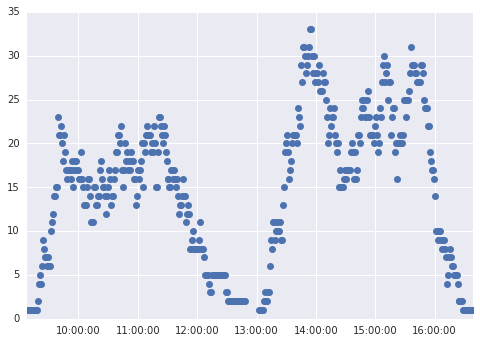

In [115]:
Counter(total_time).values()
plt.plot_date(x_y.keys(),x_y.values())
#add annotations to mouse start times?

# 2) Why are cells not getting uploaded?

In [61]:
print len(histo_df)
print len(histo_df[histo_df['Specimen Name'] == 'no cell'])
print len(histo_df[histo_df['Outcome'] == 'FAILURE'])

2035
1389
1389


In [92]:
failure = histo_df[histo_df['Outcome'] == 'FAILURE']

#Pipette problems = Pipette Broken, Pipette Clogged, Pipette Resistance Out of Range
#Seal problems = Seal Failed, Unstable Seal
#Breakin failed = Breakin Failed
#Bad Patch = Vrest out of range, access resistance out of range
#Kitchen Sink = EVERYTHING IS TERRIBLE
#unmarked problems

failure['failure'] = None

for i, event in enumerate(failure['Outcome Notes']):
    if type(event) == str:
        outcome = event.split(',')[0]
        if outcome == 'Pipette Broken':
            failure['failure'].iloc[i] = 'Pipette Problems'
        elif outcome == 'Pipette Clogged':
            failure['failure'].iloc[i] = 'Pipette Problems'
        elif outcome == 'Pipette Resistance Out of Range':
            failure['failure'].iloc[i] = 'Pipette Problems'
        elif outcome == 'Seal Failed':
            failure['failure'].iloc[i] = 'Seal Problems'
        elif outcome == 'Unstable Seal':
            failure['failure'].iloc[i] = 'Seal Problems'
        elif outcome == 'Breakin Failed':
            failure['failure'].iloc[i] = 'Breakin Failed'
        elif outcome == 'Vrest Out of Range':
            failure['failure'].iloc[i] = 'Bad Patch'
        elif outcome == 'Access Resistance Out of Range':
            failure['failure'].iloc[i] = 'Bad Patch'
        elif outcome == 'EVERYTHING IS TERRIBLE':
            failure['failure'].iloc[i] = 'Kitchen Sink'

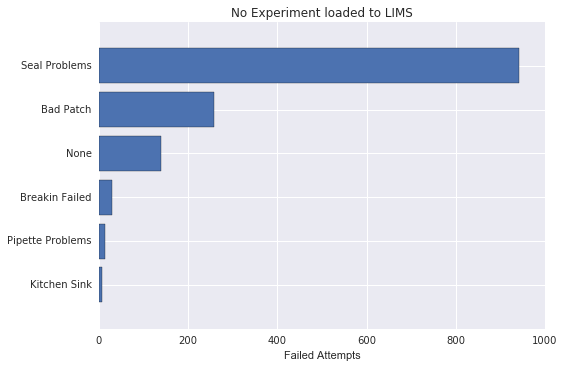

In [141]:
import seaborn
categories = Counter(failure['failure'])
plt.barh(np.arange(0,len(categories)),sorted(categories.values()), align = 'center')
plt.yticks(np.arange(0,len(categories)),sorted(categories,key=categories.get))
plt.title('No Experiment loaded to LIMS')
plt.xlabel('Failed Attempts')

In [138]:
print sorted(categories,key=categories.get)
print sorted(categories.values())

['Kitchen Sink', 'Pipette Problems', 'Breakin Failed', None, 'Bad Patch', 'Seal Problems']
[8, 13, 29, 139, 258, 942]


In [139]:
categories

Counter({None: 139,
         'Bad Patch': 258,
         'Breakin Failed': 29,
         'Kitchen Sink': 8,
         'Pipette Problems': 13,
         'Seal Problems': 942})